In [1]:
#pylint: disable=wrong-import-position
# pylint: disable=no-member
from datetime import datetime
import sys
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
sys.path.append("./Methods")
plt.style.use('seaborn')
#pylint: disable=wrong-import-position
from download import download_file #pylint: disable=wrong-import-position
from emission import add_emission #pylint: disable=wrong-import-position
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import warnings

#testcomments
class EnergyClass:
    '''
    class that contain different methods that works
    with data related to energy consumption worldwide
    Parameters
    depend on the method called
    ------------
    Returns
    depend on the method called
    ---------
    '''
    def __init__ (self):
        '''
        Init method of the class EnergyClass
        Parameters
        nothing
        ------------
        Returns
        nothing
        ---------
        '''
        self.data = ""
        self.file = False
        download_file()
    def download(self):
        '''
        Download Energy.csv file and assign it to variable named data as pandas dataframe
        Parameters
        ------------
        Returns
        ---------
        '''
        self.data = pd.read_csv("./Download/Energy.csv")
        self.data = self.data[self.data["year"]>= 1970]
        self.data["year"] = pd.to_datetime(self.data["year"],format = "%Y")
        self.data = self.data.set_index("year")
        self.data = self.data.drop(columns = ["renewables_consumption"])
        add_emission(self.data)
        self.file = True
    def country_list(self):
        '''
        Lists all unique countries that are in the given Energy.csv File in the "country" column
        Parameters
        ------------
        Returns
        ---------
        List of countries in country column.
        Example
        ---------
        x.country_list()
        with x being an Energy class object.
        '''
        if self.file is False:
            self.download()
        return self.data["country"].unique()
    def plot_consumption(self,country: str,normalize: bool = "False"):
        '''
        Plot the consumption of the desired country in terms of different energy sources
        Parameters
        ------------
        country: str
        Returns
        ---------
        Area plot
        Example
        ---------
        x.plot_consumptiont("Portugal",normalize =True)
        with x being an EnergyClass object.
        '''
        if self.file is False:
            self.download()
        if country not in self.data["country"].unique():
            raise ValueError("Variable is not part of the countries in the dataframe.")
        if normalize is False:
            df2 = self.data[ self.data["country"] == country]\
            [self.data.columns[self.data.columns.str.contains( "_consumption|country|year" )]]
            df2 = df2.drop(["fossil_fuel_consumption","low_carbon_consumption",\
                            "primary_energy_consumption"],axis=1)
        else: #Normalize Data
            values = self.data[self.data["country"] == country]\
            [self.data.columns[self.data.columns.str.contains("_consumption")]]
            values = values.drop(["fossil_fuel_consumption","low_carbon_consumption",\
                                  "primary_energy_consumption"],axis=1)
            values = values.fillna(0)
            x_scaled = values.div(values.sum(axis=1), axis=0).reset_index(drop=True)
            x_scaled.index = self.data[self.data["country"] == country]\
            [self.data.columns[self.data.columns.str.contains("_consumption|country")]].index
            df2 = x_scaled
        #Plot all consumption
        df2.plot.area()
    def energy_compare(self, countries: list):
        '''
        Takes a list of countries and iterates over it to find the\
        respective value in the dataset for the total energy consumed\
        and level of CO2 emit
        Appends each country element to loca : list
        Appends each value of that country's consumption to val : list
        Plot a barchart of each country in the list and their\
        energy consumption for the sake of comparison
        Parameters
        ---------------
        countries: list
            list of country strings
        Output
        ---------------
        figure: BarContainer
            compare the total consumption of each country
                Dashed line
            compare the total CO2 emit
        '''
        if self.file is False:
            self.download()
        #get the df of the consumption columns
        df_consumption = self.data.filter(like = "_consumption")
        df_country = self.data[["country","emissions"]]#get the df of the country column
        #merge the two dfs into 'df' having the columns of country and all the consumptions
        df_countries = pd.concat([df_country, df_consumption], axis=1)
        #group by countries and compute the averge of each consumption over the years
        #'new_df' having index label as country and counsumptions columns
        new_df = df_countries.groupby("country").mean()
        #compute the sum of all consumptions into TOTAL
        new_df["TOTAL_energy_consumption"] = new_df.iloc[:,1:].sum(axis = 1)
        final_df = new_df[["TOTAL_energy_consumption", "emissions"]]
        f_df = final_df.reset_index()
        loca = []
        val = []
        emis = []
        for country in countries:
            if country not in f_df["country"].tolist():
                raise ValueError(f"Country {country} not on the list of countries")
            value = f_df[f_df["country"] == country]["TOTAL_energy_consumption"].values[0]
            value_emis = f_df[f_df["country"] == country]["emissions"].values[0]
            loca.append(country)
            val.append(value)
            emis.append(value_emis)
        df_plot = pd.DataFrame({'Energy': val, 'Emission': emis, "Country": loca},\
        columns=['Energy','Emission','Country'])
        fig, ax1 = plt.subplots()
        ax1.set_xlabel("Countries")
        ax1.bar(df_plot["Country"], df_plot["Energy"], color="blue")
        ax1.tick_params(axis='y', labelcolor="blue")
        ax2 = ax1.twinx()
        ax2.plot(df_plot["Country"], df_plot["Emission"], color="red", linestyle='dashed')
        ax2.tick_params(axis='y', labelcolor="red")
        plt.grid(False)
        plt.show()
        #METHOD 5
    def gdp_compare(self, countries: list):
        '''
        Takes a list of countries and iterates over it to create a\
        dataframe temp : DataFrame for each country and plots\
        the column "gdp" of that country over the years
        Parameters
        ---------------
        countries: list
            list of country strings
        Output
        ---------------
        figure: AxesSubplot
            compare the GDP of each country over the years
        '''
        if self.file is False:
            self.download()
        #create new dataframe made of three columns: "country", and "gdp"
        gdp_df = self.data[["country", "gdp"]]
        for country in countries:
            if country not in gdp_df["country"].tolist():
                raise ValueError(f"Country {country} not on the list of countries")
            element = gdp_df[gdp_df["country"] == country]
            plt.plot(element.index.year,element["gdp"], label = country)
        plt.title("GDP over the years")
        plt.legend()
    #METHOD 6
    def gapminder(self, year: int):
        '''
        Takes an argument representing the year\
        if the argument is not an int, raises TypeError, else\
        plots scatter plot for the given year with the x-axis\
        the GDP and y-axis the total consumption.
        the size of the scatters is proportional to the population
        Parameters
        ---------------
        year: int
            Year where the energy consumptions are summed and plotted
        Output
        ---------------
        figure: ScatterPlot
            In reference to the gapminder tool
        '''
        if self.file is False:
            self.download()
        #'tempdf1' having one column representing the sum of \
        #all consumptions per country per year with redudant columns removed
        if type(year) not in [int]:
            raise TypeError("variable 'Year' is not an int")
        tempdf1 = self.data[self.data.index.year == year].filter( like= "_consumption" ).sum(axis=1).to_frame()
        #.drop([ "fossil_fuel_consumption","low_carbon_consumption" , \
         #      "primary_energy_consumption" ],axis=1)\
        
        tempdf2 = self.data[self.data.index.year == year][["country", "gdp", "population"]]
        tempdf3= pd.concat([tempdf1, tempdf2], axis=1)
        tempdf3 = tempdf3.dropna()
        tempdf3 = tempdf3[tempdf3["country"] != "World"]
        gap = tempdf3.set_axis(["energy","country", "gdp", "population"], axis = 1)
        #print(gap)
        gap["population"] = (gap["population"]/1000000).round(2)
        plt.scatter(gap["gdp"],gap["energy"], s=gap["population"], alpha = 0.8)
        plt.xlabel("GDP of countries")
        plt.ylabel("Energy consumption")
        plt.title(f"Gapminder scatter of Energy consumed per GDP of countries in {year}")
        plt.xscale("log")
        plt.yscale("log")
        plt.show()
    #Method 7
    def emissions_consumption(self, year1: int = 2000, year2: int = 2018 ):
        '''
        Takes two years as an interval of data related to energy consumption and emession \
        and output a scatter plot between emessions and total energy consumption \
        with size of the dots and colors reflecting countries´s populations.
        Parameters
        ---------------
        year1: str
               Begining year
        year2: str
               Ending year
        Output
        ---------------
        figure: Scatter plot
            of emissions and total energy consumption\
            size and color of dots reflect countries´s average\
            population during the chosen period.
        '''
        data = self.data
        data.reset_index(inplace=True)
        data = data.rename(columns = {'index':'year'})
        if str(year1) not in data['year'].dt.strftime('%Y').tolist():
            raise ValueError(f"year {year1} not on the list of years")
        if str(year2) not in data['year'].dt.strftime('%Y').tolist():
            raise ValueError(f"year {year2} not on the list of years")
        if year1 >= year2:
            raise ValueError(f" first year: {year1} \
            should be stricly less than second year: {year2}")
        data = data[(data["year"].dt.strftime('%Y').astype(int) >= year1) \
                    & (data["year"].dt.strftime('%Y').astype(int)<= year2)]
        df_consumption = data.filter(like = "_consumption")
        df_country = data[["country","emissions"]]#get the df of the country column
        df_countries = pd.merge(df_country, df_consumption, left_index = True, right_index = True)
        new_df = df_countries.groupby("country").mean()
        #compute the sum of all consumptions into TOTAL
        new_df["TOTAL_energy_consumption"] = new_df.iloc[:,1:].sum(axis = 1)
        final_df = new_df[["TOTAL_energy_consumption", "emissions"]]
        f_df = final_df.reset_index()
        df_population = data[["country","population"]]#get the df of the country column
        df_population = df_population.groupby("country").mean()
        df_population = df_population.reset_index()
        df_scatter = pd.merge(df_population, f_df, left_index = True, right_index = True)
        df_scatter.drop( df_scatter[ df_scatter['country_x'] == "World" ].index , inplace=True)
        fig = plt.figure(figsize=(18, 10))
        #plt_1 = plt.figure(figsize=(18, 10))
        ax = plt.gca()
        cm = plt.cm.get_cmap('RdYlBu')
        scatter = ax.scatter(df_scatter["emissions"], df_scatter["TOTAL_energy_consumption"] \
                             , s= df_scatter["population"]/1000000 \
                             ,c=df_scatter["population"]/1000000 ,vmin=0 \
                             , vmax=200, alpha=0.5 , cmap=cm)
        plt.colorbar(scatter)
        ax.set_yscale('log')
        ax.set_xscale('log')
        plt.title(f"Emissions and consumption for all countries between {year1} and {year2}" \
                  , fontdict=None, loc='center')
        plt.xlabel("Emissions of gC02eq/kWh")
        plt.ylabel("Total energy consumption")
        handles, labels = scatter.legend_elements(prop="sizes", alpha=0.4)
        legend2 = ax.legend(handles, labels, loc="lower right", title="Sizes")
        
    def arima_prediction(self, country: str, n_periods: int):
        '''
        Takes a country identifier and a number of periods for future predictions. 
        Uses the ARIMA algorithm for prediction. The hyperparameters are chosen based on iteration of\
        all the combinations within their given range and finding the tuple that yields the smallest rmse.
        Fits the data and predicts the outcome of both emissions and consumptions for the given country over\
        the given number of periods.
        plots the two graphs of ARIMA prediction for emission and consumption stacked horizentally together.
        Parameters
        ---------------
        country: string
                name of the country to do the ARIMA prediction on
        
        n_periods: integer
                number of periods to predict
        
        ---------------
        Figure: subplots one for the emission prediction and th eother for consumption prediction
        '''
        if self.file is False:
            self.download()
        if (type(n_periods) not in [int]) or (n_periods < 1):
            raise Exception("Sorry, prediction periods must be an integer and bigger or equal to 1")
        warnings.filterwarnings("ignore")
        df_em = self.data[self.data["country"] == country]
        df_cons = self.data[self.data["country"] == country].filter(like = "_consumption").dropna()\
        .sum(axis = 1).to_frame().set_axis(["all_consumptions"], axis = 1)
        if (df_em["emissions"].isna().sum()>35):
            raise Exception(f"Sorry, {country} does not have enough emission data to perform ARIMA")
            return
        df_em = df_em.filter(like = "em").dropna()
        train = df_em["emissions"][:int(len(df_em["emissions"])*0.8)]
        test = df_em["emissions"][int(len(df_em["emissions"])*0.8):]
        p, d, q = range(0,7), range(0,2), range(0,7)
        pdq_comb = list(itertools.product(p, d, q))
        rmse = []
        order = []
        for pdq in pdq_comb:
            try:
                model = sm.tsa.arima.ARIMA(train, order = pdq).fit()
                pred = model.predict(start = int(len(df_em["emissions"])*0.8),end = (len(df_em["emissions"])-1))
                error = np.sqrt(mean_squared_error(test, pred))
                order.append(pdq)
                rmse.append(error)
            except:
                continue 
        results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
        hyperparameters = results.nsmallest(1, "RMSE").index[0]
        final_model = sm.tsa.arima.ARIMA(df_em["emissions"], order = hyperparameters).fit()
        prediction = final_model.predict(len(df_em), len(df_em)+n_periods)    
        final_model2 = sm.tsa.arima.ARIMA(df_cons["all_consumptions"], order = hyperparameters).fit()
        prediction2 = final_model2.predict(len(df_cons), len(df_cons)+n_periods)
        f, (ax1, ax2) = plt.subplots(1, 2)  
        ax1.plot(df_em, color = "cornflowerblue")
        ax1.plot(prediction, label="predictions", color = "yellowgreen")
        ax1.set_title("ARIMA Emissions Prediction")
        ax2.plot(df_cons, color = "cornflowerblue")
        ax2.plot(prediction2, label="predictions", color = "red")
        ax2.set_title("ARIMA Consumptions Prediction")
        plt.tight_layout(4)

In [3]:
x = EnergyClass()

File already exists !


In [ ]:
x.energy_compare(["France", "Spain", "Japan"])

In [ ]:
x.gapminder(2007)

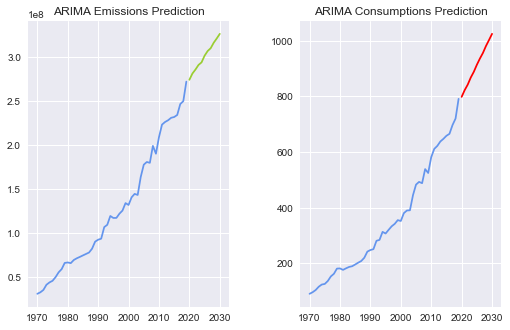

In [4]:
x.arima_prediction("Morocco", 10)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
df = x.download()

In [ ]:
df

In [ ]:
df[df["country"] == "Tunisia"][["emissions"]]

In [ ]:
df["sum"] = df["solar_consumption"] + df["wind_consumption"] 
df["sub"] = df["renewables_consumption"] - df["sum"]
df[["sub"]].sum()

In [ ]:
df[["other_renewable_consumption", "hydro_consumption", "biofuel_consumption"]].sum()

In [ ]:
69729.5 + 803761.772 + 32805.332

In [ ]:
df_em = df.filter(like = "em")[df["country"] == "China"].dropna()
#

In [ ]:
test_result = adfuller(df_em["emissions"])

In [ ]:
#H0: not stationary
#H1: stationary

def adfuller_test(emissions):
    result = adfuller(emissions)
    labels = ["ADF Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"]
    for value, label in zip(result, labels):
        print(label+ ": "+ str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject H0, Data is likely stationary")
    else:
        print("Weak evidence against null hypothesis, Data is likely non stationary")
    
    


In [ ]:
adfuller_test(df_em["emissions"])

In [ ]:
df_em_diff = df_em.diff(periods = 2).dropna()

In [ ]:
adfuller_test(df_em_diff["emissions"])

In [ ]:
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.plot(df_em_diff)

In [ ]:
"""def ad_test(dataset):
    dftest = adfuller(dataset, autolag = "AIC")
    print("1. ADF :", dftest[0])
    print("2. P_Value :", dftest[1])
    print("3. Num of Lags :", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values: ")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)"""

In [ ]:
#ad_test(df_em["emissions"])

In [ ]:
"""rolling_mean = df_em.rolling(window = 2).mean()
rolling_std = df_em.rolling(window = 2).std()
plt.plot(df_em, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()"""

In [ ]:
"""result = adfuller(df['emissions'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))"""

In [ ]:
#plot_acf(df_em)

In [ ]:
#df_em_diff = df_em.diff(periods = 1)
#df_em_diff

In [ ]:
#plot_acf(df_em_diff)

In [ ]:
df_em['emissions First Difference'] = df_em['emissions'] - df_em['emissions'].shift(1)
#df_em['Seasonal First Difference']=df_em['emissions']-df_em['emissions'].shift(1)
df_em.head()

In [ ]:
df_em_diff.plot()

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_em_diff['emissions'])
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_em_diff['emissions'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_em_diff['emissions'].dropna(),lags=23,ax=ax2)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import numpy as np
model=sm.tsa.arima.ARIMA(df_em_diff['emissions'],order=(1,1,0))
model_fit=model.fit()
model_fit.summary()

In [ ]:
#model_fit.plot()

In [ ]:
df_em_diff['forecast']=model_fit.predict(start=0,end=70,dynamic=True)
df_em_diff[['emissions','forecast']].plot(figsize=(12,8))

In [ ]:
df_em_diff(forecast(auto.arima(ts(temps,frequency=365),D=1),h=365))

In [ ]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_em['emissions'], model='additive', 
                            extrapolate_trend='freq') #additive or multiplicative is data specific
fig = decomposition.plot()
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
df_em["emissions"].head()

In [ ]:
#df_em["emissions"].plot()

import pmdarima
from pmdarima import auto_arima

auto_arima(df_em["emissions"], m=12, d=1, start_P = 0, seasonal = False, trace = False, error_action="ignore", suppress_warnings=True,stepwise=False)

In [ ]:
final_model = sm.tsa.arima.ARIMA(df_em["emissions"], order = (2,1,1)).fit()
final_model
#df_em["emissions"]

In [ ]:
#df_em_diff.plot()

In [ ]:
#df_em["emissions"].plot()

import pmdarima
from pmdarima import auto_arima

auto_arima(df_em["emissions"], m=12, d=1, start_P = 0, seasonal = False, trace = False, error_action="ignore", suppress_warnings=True,stepwise=False)

In [ ]:
prediction = final_model.predict(len(df_em), len(df_em)+10)
prediction

In [ ]:
df_em.plot(legend = True, label = "Train", figsize =(10,6))
prediction.plot(legend=True, label="prediction")

In [ ]:
import numpy as np

In [ ]:
train = df_em["emissions"][:40]
test = df_em["emissions"][40:]

In [ ]:
len(train)

In [ ]:
import itertools
from sklearn.metrics import mean_squared_error

p = range(0,7)
d = range(0,2)
q = range(0,7)

In [ ]:
p = range(0,7)
d = range(0,2)
q = range(0,7)
pdq_comb = list(itertools.product(p, d, q))
rmse = []
order = []

for pdq in pdq_comb:
    try:
        model = sm.tsa.arima.ARIMA(train, order = pdq).fit()
        pred = model.predict(start = 40,end = 49)
        error = np.sqrt(mean_squared_error(test, pred))
        order.append(pdq)
        rmse.append(error)
        
    except:
        continue
    

In [ ]:
len(test)

In [ ]:
rmse = []
order = []

In [ ]:
for pdq in pdq_comb:
    try:
        model = sm.tsa.arima.ARIMA(train, order = pdq).fit()
        pred = model.predict(start = 40,end = 49)
        error = np.sqrt(mean_squared_error(test, pred))
        order.append(pdq)
        rmse.append(error)
        
    except:
        continue
    

In [ ]:
results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
hyperparameters = results.nsmallest(1, "RMSE").index[0]

In [ ]:
hyperparameters = results.nsmallest(1, "RMSE").index[0]

In [ ]:
#######

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")


df_em = df.filter(like = "em")[df["country"] == "China"].dropna()
df_cons = df[df["country"] == "China"].filter(like = "_consumption").dropna()\
.sum(axis = 1).to_frame().set_axis(["all_consumptions"], axis = 1)


train = df_em["emissions"][:int(len(df_em["emissions"])*0.8)]
test = df_em["emissions"][int(len(df_em["emissions"])*0.8):]

train2 = df_cons["all_consumptions"][:int(len(df_cons["all_consumptions"])*0.8)]
test2 = df_cons["all_consumptions"][int(len(df_cons["all_consumptions"])*0.8):]

p = range(0,5)
d = range(0,2)
q = range(0,5)

pdq_comb = list(itertools.product(p, d, q))

rmse = []
order = []

In [ ]:
df_cons = df[df["country"] == "Russia"].filter(like = "_consumption").dropna()\
.sum(axis = 1).to_frame().set_axis(["all_consumptions"], axis = 1)


df_cons.head(2)


In [ ]:
for pdq in pdq_comb:
    try:
        model = sm.tsa.arima.ARIMA(train, order = pdq).fit()
        pred = model.predict(start = int(len(df_em["emissions"])*0.8),end = (len(df_em["emissions"])-1))
        error = np.sqrt(mean_squared_error(test, pred))
        order.append(pdq)
        rmse.append(error)
        
        
    except:
        continue


In [ ]:
#results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
#hyperparameters = results.nsmallest(1, "RMSE").index[0]

In [ ]:
df_cons.plot()

In [ ]:
results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
#print(results)

In [ ]:
prediction2 = final_model.predict(len(df_cons), len(df_cons)+10)
print(prediction2)

In [ ]:
prediction2

In [ ]:
results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
hyperparameters = results.nsmallest(1, "RMSE").index[0]
#df_em = df.filter(like = "em")[df["country"] == "Morocco"].dropna()

final_model = sm.tsa.arima.ARIMA(df_em["emissions"], order = hyperparameters).fit()
#final_model
prediction = final_model.predict(len(df_em), len(df_em)+10)
#prediction


final_model2 = sm.tsa.arima.ARIMA(df_cons["all_consumptions"], order = hyperparameters).fit()

prediction2 = final_model2.predict(len(df_cons), len(df_cons)+10)
f, (ax1, ax2) = plt.subplots(1, 2)p

#plt.subplot(1,2,1)
#plt.subplot(1, 2, 1)
#df_em.plot(color = "cornflowerblue")
#prediction.plot(legend=True, label="predictions", color = "yellowgreen")

#plt.subplot(1, 2, 2)
#df_cons.plot(color = "cornflowerblue")
#prediction2.plot(legend=True, label="predictions", color = "yellowgreen")
f, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)



ax1.plot(df_em, color = "cornflowerblue")
ax1.plot(prediction, label="predictions", color = "yellowgreen")
ax1.set_title("ARIMA Emissions Prediction")
ax2.plot(prediction2, label="predictions", color = "yellowgreen")
ax2.plot(df_cons, color = "cornflowerblue")
ax2.set_title("ARIMA Consumptions Prediction")

plt.tight_layout(4)
#ax2.plot(prediction2, label="predictions", color = "yellowgreen")
#prediction.plot(legend=True, label="predictions", color = "yellowgreen")

    def arima_prediction(self, country: strp, n_periods: int):
        if self.file is False:
            self.download()
        if (type(n_periods) not in [int]) or (n_periods < 1):
            raise Exception("Sorry, prediction periods must be an integer and bigger or equal to 1")
        
        warnings.filterwarnings("ignore")

        df_em = self.data[self.data["country"] == country]
        if (df_em["emissions"].isna().sum()>35):
            raise Exception(f"Sorry, {country} does not have enough emission data to perform ARIMA")
            return
        df_em = df_em.filter(like = "em").dropna()
        train = df_em["emissions"][:int(len(df_em["emissions"])*0.8)]
        test = df_em["emissions"][int(len(df_em["emissions"])*0.8):]
        
        p = range(0,7)
        d = range(0,2)
        q = range(0,7)

        pdq_comb = list(itertools.product(p, d, q))

        rmse = []
        order = []
        
        for pdq in pdq_comb:
            try:
                model = sm.tsa.arima.ARIMA(train, order = pdq).fit()
                pred = model.predict(start = int(len(df_em["emissions"])*0.8),end = (len(df_em["emissions"])-1))
                error = np.sqrt(mean_squared_error(test, pred))
                order.append(pdq)
                rmse.append(error)
        
            except:
                continue
                
        results = pd.DataFrame(index = order, data=rmse, columns = ["RMSE"])
        hyperparameters = results.nsmallest(1, "RMSE").index[0]

        final_model = sm.tsa.arima.ARIMA(df_em["emissions"], order = hyperparameters).fit()
        prediction = final_model.predict(len(df_em), len(df_em)+n_periods)
        
        df_em.plot(color = "cornflowerblue")
        prediction.plot(legend=True, label="predictions", color = "yellowgreen")